In [2]:
import pandas as pd
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import GridSearchCV

from matplotlib import pyplot as plt
import numpy as np

[nltk_data] Downloading package punkt to /home/yarburart/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Анализ и подготовка данных

In [3]:
df = pd.read_csv("./data/SPAM_text_message_20170820-Data.csv")

In [4]:
df.shape

(5572, 2)

In [5]:
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df["Category"].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [8]:
ham_dict = {'ham':0, 'spam':1}
df['Category'] = df['Category'].apply(lambda x: ham_dict[x])

In [9]:
df.head(5)

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
for mess in df[df['Category'] == 1]['Message'].head(5):
    print(mess)

Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030
SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info


In [14]:
for mess in df[df['Category'] == 0]['Message'].head(5):
    print(mess)

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Ok lar... Joking wif u oni...
U dun say so early hor... U c already then say...
Nah I don't think he goes to usf, he lives around here though
Even my brother is not like to speak with me. They treat me like aids patent.


In [16]:
train_df, test_df = train_test_split(df, test_size=500)

In [17]:
test_df['Category'].value_counts()

0    426
1     74
Name: Category, dtype: int64

In [18]:
train_df['Category'].value_counts()

0    4399
1     673
Name: Category, dtype: int64

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/yarburart/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [22]:
sentence_example = df.iloc[1]["Message"]
tokens = word_tokenize(sentence_example, language="english")
tokens_without_punctuation = [i for i in tokens if i not in string.punctuation]
stop_words = stopwords.words("english")
tokens_without_stop_words_and_punctuation = [i for i in tokens_without_punctuation if i not in stop_words]
snowball = SnowballStemmer(language="english")
stemmed_tokens = [snowball.stem(i) for i in tokens_without_stop_words_and_punctuation]

In [24]:
print(f"Исходный текст: {sentence_example}")
print("-----------------")
print(f"Токены: {tokens}")
print("-----------------")
print(f"Токены без пунктуации: {tokens_without_punctuation}")
print("-----------------")
print(f"Токены без пунктуации и стоп слов: {tokens_without_stop_words_and_punctuation}")
print("-----------------")
print(f"Токены в одном регистре (стеминг): {stemmed_tokens}")

Исходный текст: Ok lar... Joking wif u oni...
-----------------
Токены: ['Ok', 'lar', '...', 'Joking', 'wif', 'u', 'oni', '...']
-----------------
Токены без пунктуации: ['Ok', 'lar', '...', 'Joking', 'wif', 'u', 'oni', '...']
-----------------
Токены без пунктуации и стоп слов: ['Ok', 'lar', '...', 'Joking', 'wif', 'u', 'oni', '...']
-----------------
Токены в одном регистре (стеминг): ['ok', 'lar', '...', 'joke', 'wif', 'u', 'oni', '...']


In [25]:
snowball = SnowballStemmer(language="english")
russian_stop_words = stopwords.words("english")

def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language="english")
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

In [26]:
tokenize_sentence(sentence_example)

['ok', 'lar', '...', 'joke', 'wif', 'u', 'oni', '...']

In [27]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))

In [29]:
features = vectorizer.fit_transform(train_df["Message"])

## Обучение модели LogisticRegression

In [30]:
model = LogisticRegression(random_state=0)
model.fit(features, train_df["Category"])

LogisticRegression(random_state=0)

In [32]:
model.predict(features[0])

array([1])

In [33]:
train_df['Message'].iloc[0]

'Hope you enjoyed your new content. text stop to 61610 to unsubscribe. help:08712400602450p Provided by tones2you.co.uk'

In [35]:
model_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ('model', LogisticRegression(random_state=0))
])

In [36]:
model_pipeline.fit(train_df['Message'], train_df['Category'])

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7f5453d03be0>)),
                ('model', LogisticRegression(random_state=0))])

## Анализ качества модели 

In [43]:
model_pipeline.predict(['hello'])

array([0])

In [47]:
model_pipeline.predict(["many days of FREE Premium. Simply text the password to verifi We are trying to contact you."])

array([1])

In [48]:
precision_score(y_true=test_df["Category"], y_pred=model_pipeline.predict(test_df["Message"]))

1.0

In [49]:
recall_score(y_true=test_df["Category"], y_pred=model_pipeline.predict(test_df["Message"]))

0.7297297297297297

In [50]:
prec, rec, thresholds = precision_recall_curve(y_true=test_df["Category"], probas_pred=model_pipeline.predict_proba(test_df["Message"])[:, 1])

/home/yarburart/Документы/code/DataScience/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


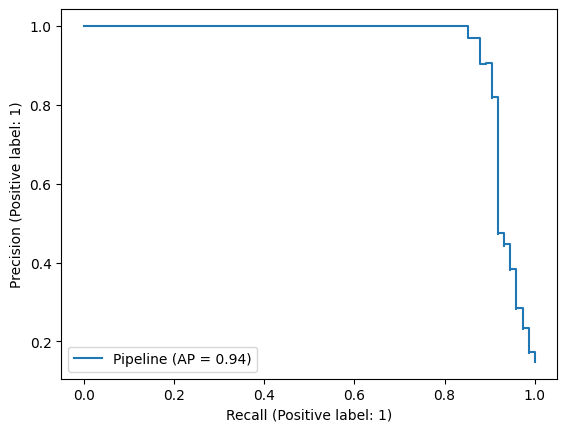

In [51]:
plot_precision_recall_curve(estimator=model_pipeline, X=test_df["Message"], y=test_df["Category"])

In [52]:
np.where(prec>0.95)

(array([425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437,
        438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450,
        451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463,
        464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476,
        477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489,
        490, 491, 492, 493]),)

In [64]:
thresholds[425]

0.2601073970876247

In [65]:
precision_score(y_true=test_df["Category"], y_pred=model_pipeline.predict_proba(test_df["Message"])[:, 1] > thresholds[425])

0.9701492537313433

In [66]:
recall_score(y_true=test_df["Category"], y_pred=model_pipeline.predict_proba(test_df["Message"])[:, 1] > thresholds[425])

0.8783783783783784

## Дообучение модели

In [56]:
grid_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", 
     GridSearchCV(
        LogisticRegression(random_state=0),
        param_grid={'C': [0.1, 1, 10.]},
        cv=3,
         verbose=4
        )
    )
])

In [57]:
grid_pipeline.fit(train_df["Message"], train_df["Category"])

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END .............................C=0.1;, score=0.867 total time=   0.0s
[CV 2/3] END .............................C=0.1;, score=0.868 total time=   0.0s
[CV 3/3] END .............................C=0.1;, score=0.867 total time=   0.0s
[CV 1/3] END ...............................C=1;, score=0.936 total time=   0.0s
[CV 2/3] END ...............................C=1;, score=0.948 total time=   0.0s
[CV 3/3] END ...............................C=1;, score=0.947 total time=   0.0s
[CV 1/3] END ............................C=10.0;, score=0.973 total time=   0.1s
[CV 2/3] END ............................C=10.0;, score=0.978 total time=   0.1s
[CV 3/3] END ............................C=10.0;, score=0.972 total time=   0.1s


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7f545335cee0>)),
                ('model',
                 GridSearchCV(cv=3,
                              estimator=LogisticRegression(random_state=0),
                              param_grid={'C': [0.1, 1, 10.0]}, verbose=4))])

In [58]:
model_pipeline_c_10 = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state=0, C=10.))
])

In [59]:
model_pipeline_c_10.fit(train_df["Message"], train_df["Category"])

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7f54533d1990>)),
                ('model', LogisticRegression(C=10.0, random_state=0))])

In [60]:
prec_c_10, rec_c_10, thresholds_c_10 = precision_recall_curve(y_true=test_df["Category"], probas_pred=model_pipeline_c_10.predict_proba(test_df["Message"])[:, 1])

/home/yarburart/Документы/code/DataScience/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


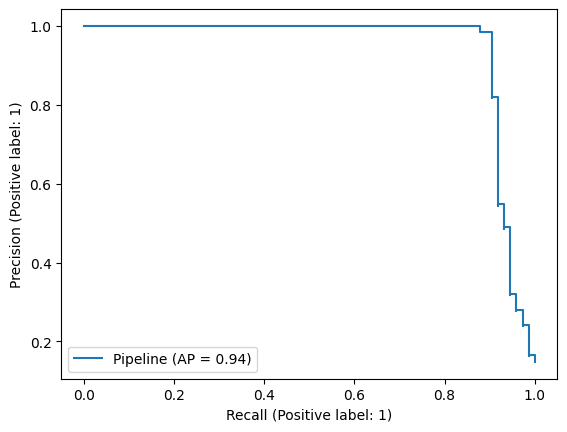

In [69]:
plot_precision_recall_curve(estimator=model_pipeline_c_10, X=test_df["Message"], y=test_df["Category"])

In [61]:
np.where(prec_c_10 >0.95)

(array([423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435,
        436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448,
        449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461,
        462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474,
        475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487,
        488, 489, 490, 491, 492, 493]),)

In [67]:
precision_score(y_true=test_df["Category"], y_pred=model_pipeline_c_10.predict_proba(test_df["Message"])[:, 1] > thresholds_c_10[423])

0.9710144927536232

In [68]:
recall_score(y_true=test_df["Category"], y_pred=model_pipeline_c_10.predict_proba(test_df["Message"])[:, 1] > thresholds_c_10[423])

0.9054054054054054